In [32]:
import os
from scipy import ndimage, misc
from matplotlib import pyplot as plt
import numpy as np
import imageio
%matplotlib inline
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split

In [36]:
# get excel file
current_dir = Path.cwd()
file = pd.ExcelFile(current_dir / 'County_Training_Test_Normalized_2.xlsx')

# convert to dataframe
df = file.parse("Training Data")

# get dataset
dataset = df.to_numpy()
# print(dataset)

# get features for datapoints
X = np.delete(dataset, [0,1,7,8], axis=1)
X = X.astype(float)
num_features = X.shape[1]
# print(num_features)
# print(X)

# get labels
# 7 corresponds to voter turnout, 8 corresponds to voter turnout in 0,1,2 buckets 
Y = dataset[:,[7]]
Y = Y.astype(float)
Y = Y.ravel()
# print(Y)
Y_bucket = dataset[:,[8]]
Y_bucket = Y_bucket.astype(float)
Y_bucket = Y_bucket.ravel()

# get counties
counties = dataset[:,[1]]

# get feature names
new_df = df.drop("County", axis=1)
new_df = new_df.drop("States", axis=1)
new_df = new_df.drop("Percentage Voter Turnout", axis=1)
new_df = new_df.drop("Labels", axis=1)
feature_names = list(new_df.columns.values)

# print(feature_names)

scaler = preprocessing.StandardScaler()
scaler.fit(X)
X = scaler.transform(X) + 2
# print(Y)

In [57]:
#test train split
np.random.seed(1)
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)

In [35]:
# perform PCA to reduce to 2 dimensions
pca = sklearnPCA(n_components=2) #2-dimensional PCA
features = pca.fit_transform(X)
feat_test = pca.transform(X_test)

In [47]:
#encode labels
le = preprocessing.LabelEncoder()
encoded_Y = le.fit_transform(Y)
encoded_Y_test = le.fit_transform(Y_test)

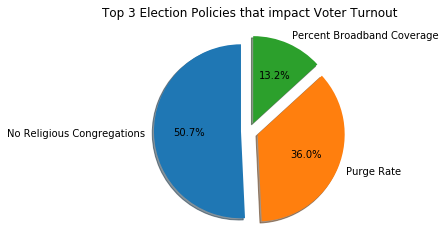

In [52]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel

# convert Y to classes based on threshold
threshold = np.mean(Y)
labels = Y.copy()
labels[labels < threshold] = 0 # low turnout
labels[labels >= threshold] = 1 # high turnout

# Visualize feature importance
K = 3
explode = np.zeros(K)
explode[:K] = 0.1
model = SelectKBest(f_regression, k=K)
model.fit_transform(X, labels)
indices = np.argsort(model.scores_)[::-1]
top_features = []
for i in indices:
    top_features.append(feature_names[i])

fig = plt.figure()
fig.clf()
ax = fig.add_subplot(111)
plt.title("Top 3 Election Policies that impact Voter Turnout")
plt.pie(model.scores_[indices[range(K)]], labels=top_features[:K], autopct='%1.1f%%', shadow=True, startangle=90, explode=explode)
plt.show()




In [58]:
lr = LinearRegression()
# lr.fit(X,encoded_Y)
lr.fit(X,Y)


# lr_train_score=lr.score(X,encoded_Y)
lr_train_score = lr.score(X,Y)
print("LR training score:", lr_train_score)


lr_test_score = lr.score(X_test,Y_test)
print("LR testing score:", lr_test_score)


LR training score: 0.01477244337906125
LR testing score: 0.002560352180858483


In [44]:
lr = LinearRegression()
lr.fit(X,Y)
print(lr.predict(X_test)[:10])
print(Y_test[:10])
lr.coef_

[0.57167794 0.55520522 0.56771558 0.56335459 0.5875463  0.57071126
 0.55938408 0.55830099 0.56575842 0.57576326]
[0.62564338 0.73024424 0.57230704 0.62959881 0.44836176 0.57419054
 0.51882906 0.53781103 0.50852281 0.59540954]


array([ 0.00131898, -0.006724  , -0.00915377, -0.00605643, -0.00344875])